In [1]:
%reset
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import random
import treecorr
from astropy.io import fits
import pickle as pk
import os.path
from os import path




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
# old_f = np.loadtxt('/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/L3072N4096-LC129-1in700.dat')



In [3]:
# old_f.shape
# 


In [47]:
df = np.loadtxt('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100/lightcone_129_1in100.269')



In [48]:
df.shape
# nobj = df.shape[0]/3
# ind = np.random.randint(0, nobj, df.shape[0])
# print ind

# #


(156964, 4)

In [49]:
# ind = np.random.randint(0,10000,df.shape[0])
# plt.figure
# plt.scatter(df[ind,0],df[ind,1])
# plt.show()




In [50]:
# old_f.shape[0]/(1.0*df.shape[0])



In [4]:
import mycosmo as cosmodef
import scipy as sp
import scipy.interpolate as interpolate
from scipy.integrate import quad
from scipy.optimize import fsolve
import scipy.optimize as op

class general_funcs:

    def __init__(self, cosmo_params):
        h = cosmo_params['H0'] / 100.
        cosmo_func = cosmodef.mynew_cosmo(h, cosmo_params['Om0'], cosmo_params['Ob0'], cosmo_params['ns'],
                                          cosmo_params['sigma8'])
        self.cosmo = cosmo_func

    def get_Dcom(self, zf):
        c = 3 * 10 ** 5
        Omega_m, Omega_L = self.cosmo.Om0, 1. - self.cosmo.Om0
        res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
        Dcom = res1[0]
        return Dcom

    def get_Dcom_array(self,zarray):
        Omega_m = self.cosmo.Om0
        Omega_L = 1. - Omega_m
        c = 3 * 10 ** 5
        Dcom_array = np.zeros(len(zarray))
        for j in range(len(zarray)):
            zf = zarray[j]
            res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
            Dcom = res1[0]
            Dcom_array[j] = Dcom
        return Dcom_array

    def get_Hz(self,zarray):
        Omega_m = self.cosmo.Om0
        Omega_L = 1 - Omega_m
        Ez = np.sqrt(Omega_m * (1 + zarray) ** 3 + Omega_L)
        Hz = 100. * Ez
        return Hz

    def get_diff(self, zf, chi):
        return chi - self.get_Dcom(zf)

    def root_find(self, init_x, chi):
        nll = lambda *args: self.get_diff(*args)
        result = op.root(nll, np.array([init_x]), args=chi, options={'maxfev': 50}, tol=0.01)
        return result.x[0]

    def get_z_from_chi(self, chi):
        valf = self.root_find(0., chi)
        return valf
    
    
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.25, 'Ob0': 0.044, 'sigma8': 0.8, 'ns': 0.95}
gnf = general_funcs(cosmo_params_dict)
z_array = np.linspace(0, 1.5, 10000)
chi_array = np.zeros(len(z_array))
for j in range(len(z_array)):
    chi_array[j] = gnf.get_Dcom(z_array[j])
chi_interp = interpolate.interp1d(z_array, chi_array)


chi_array = np.linspace(0, 4000, 50000)
z_array = np.zeros(len(chi_array))
for j in range(len(z_array)):
    z_array[j] = gnf.get_z_from_chi(chi_array[j])
z_interp = interpolate.interp1d(chi_array, z_array)






In [5]:
import pdb

basedir = '/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/'

# fext = np.linspace(0,2442,2443)
# fext = np.linspace(0,2442,10)

fext1 = np.arange(1000)

fext2 = np.arange(1000,2000)

fext3 = np.arange(2000,2443)

for i in range(0,3):
    if i == 0:
        fext = fext1
    
    if i == 1:
        fext = fext2
    
    if i == 2:
        fext = fext3
        
    ra, dec, z_true, chi_true, x_true, y_true, z_true = [], [], [], [], [], [], []
#     x_coord, y_coord, z_coord = [],[],[]
    
    for j in range(len(fext)):
        if np.mod(j, 10) == 0:
            print j
        filename = basedir + 'lightcone_129_1in100.' + str(int(fext[j]))
        if path.isfile(filename):
            data = np.loadtxt(filename)

            if len(data) > 1:
#                 nobj = data.shape[0]/7
#                 if nobj > 1:
#                     ind = np.unique(np.random.randint(0, nobj, data.shape[0]))
                if len(ra) == 0:
        
                    x = data[:, 0]
                    y = data[:, 1]
                    z = data[:, 2]

                    
#                     ra = (180/np.pi)*np.arctan(x/y) 
                    ra = (180/np.pi)*np.arctan(y/x) 
                    dec= 90.-(180/np.pi)*np.arctan(np.sqrt(x**2 + y**2)/z)
                    chival = np.sqrt(x**2 + y**2 + z**2)
                    z_true = z_interp(chival)
                    chi_true = chival
                    x_true = x
                    y_true = y
                    z_true = z
                else:
                    x = data[:, 0]
                    y = data[:, 1]
                    z = data[:, 2]
#                     ra_t = (180./np.pi)*np.arctan(x/y) 
                    ra_t = (180./np.pi)*np.arctan(y/x) 
                    dec_t= 90.-(180./np.pi)*np.arctan(np.sqrt(x**2 + y**2)/z)
                    chival = np.sqrt(x**2 + y**2 + z**2)
                    z_true_t = z_interp(chival)


                    ra = np.hstack((ra,ra_t))
                    dec = np.hstack((dec,dec_t))
                    z_true = np.hstack((z_true,z_true_t))
                    chi_true = np.hstack((chi_true, chival))
                    x_true = np.hstack((x_true, x))
                    y_true = np.hstack((y_true, y))
                    z_true = np.hstack((z_true, z))
#                 else:
#                     print('tile ' + str(j) + ' has less objects')

            else:
                print('tile ' + str(j) + ' has no or one objects')

    c1 = fits.Column(name='RA', array=np.array(ra), format='E')
    c2 = fits.Column(name='DEC', array=np.array(dec), format='E')
    c3 = fits.Column(name='Z', array=np.array(z_true), format='E')
    c4 = fits.Column(name='CHI', array=np.array(chi_true), format='E')
    c5 = fits.Column(name='PX', array=np.array(x_true), format='E')
    c6 = fits.Column(name='PY', array=np.array(y_true), format='E')
    c7 = fits.Column(name='PZ', array=np.array(z_true), format='E')

    t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])
    t.writeto( '/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/matter_ra_dec_z_L3072N4096-LC129-1in100_fromxyz_swapxy_ind_' + str(np.min(fext)) + '_' + str(np.max(fext)) + '.fits', clobber=True)    


    



0


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in divide
/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in arctan


10
20


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in divide
/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in arctan


30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.658"


tile 658 has no or one objects
660
670


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.679"


tile 679 has no or one objects
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.827"


tile 827 has no or one objects


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.829"


tile 829 has no or one objects
830
840
850
860


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.868"


tile 868 has no or one objects
870


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.873"


tile 873 has no or one objects
880
890
900
910
920
930
940
950
960
970
980
990


0
10
20
30
40
50


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1057"


tile 57 has no or one objects
60
70
80
90
100
110
120
130


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1137"


tile 137 has no or one objects
140
150


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1155"


tile 155 has no or one objects
160
170
180
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
tile 560 has no or one objects


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1560"


570


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1578"


tile 578 has no or one objects
580
590
600


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1602"


tile 602 has no or one objects


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1604"


tile 604 has no or one objects
610
620
630


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1636"


tile 636 has no or one objects
640
650
660
670
680


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in divide
/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in divide


690
700
710
720
730
740
750
760
770


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1779"


tile 779 has no or one objects
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
tile 950 has no or one objects


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1950"


960
970


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1973"


tile 973 has no or one objects
980


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.1988"


tile 988 has no or one objects
990
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.2163"


tile 163 has no or one objects


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.2165"


tile 165 has no or one objects
170
180
190
200


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.2204"


tile 204 has no or one objects


/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: loadtxt: Empty input file: "/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/matter1in100_xyz/1in100xyz/lightcone_129_1in100.2209"


tile 209 has no or one objects
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440


In [6]:
mcat1 = fits.open('/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/matter_ra_dec_z_L3072N4096-LC129-1in100_fromxyz_swapxy_ind_0_999.fits')
mcat2 = fits.open('/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/matter_ra_dec_z_L3072N4096-LC129-1in100_fromxyz_swapxy_ind_1000_1999.fits')
mcat3 = fits.open('/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/matter_ra_dec_z_L3072N4096-LC129-1in100_fromxyz_swapxy_ind_2000_2442.fits')






In [7]:
ra1, dec1, z1 = mcat1[1].data['RA'],mcat1[1].data['DEC'],mcat1[1].data['Z']

ra2, dec2, z2 = mcat2[1].data['RA'],mcat2[1].data['DEC'],mcat2[1].data['Z']

ra3, dec3, z3 = mcat3[1].data['RA'],mcat3[1].data['DEC'],mcat3[1].data['Z']




In [8]:
ra_f, dec_f, z_f = np.hstack((ra1, ra2, ra3)), np.hstack((dec1, dec2, dec3)), np.hstack((z1, z2, z3))




In [10]:
np.max(z_f)



3061.0938

In [14]:
ind_good = np.where( (z_f > 0.0) & (z_f < 1.4) & (ra_f < 90) & (ra_f > 0) & (ra_f is not None) & (dec_f > 0) & (dec_f < 90) & (dec_f is not None)  )[0]
# ind_good = np.where( (z_f > 0.0) & (z_f < 1.4) & (ra_f is not None)  & (dec_f is not None)  )[0]

print len(ind_good), len(ra_f)

ra_f, dec_f, z_f = ra_f[ind_good], dec_f[ind_good], z_f[ind_good]



/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


175595468 347909854


In [44]:
nobj_1in300 = len(ra_f)/3
nobj_1in700 = len(ra_f)/7
ind_1in300 = np.unique(np.random.randint(0, nobj_1in300, len(ra_f)))
ind_1in700 = np.unique(np.random.randint(0, nobj_1in700, len(ra_f)))



In [45]:
from astropy.io import fits
c1 = fits.Column(name='RA', array=np.array(ra_f), format='E')
c2 = fits.Column(name='DEC', array=np.array(dec_f), format='E')
c3 = fits.Column(name='Z', array=np.array(z_f), format='E')

t = fits.BinTableHDU.from_columns([c1, c2, c3])
t.writeto( '/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/matter_ra_dec_z_L3072N4096-LC129-1in100_new' + '.fits', clobber=True)    






In [46]:
from astropy.io import fits
c1 = fits.Column(name='RA', array=np.array(ra_f[ind_1in300]), format='E')
c2 = fits.Column(name='DEC', array=np.array(dec_f[ind_1in300]), format='E')
c3 = fits.Column(name='Z', array=np.array(z_f[ind_1in300]), format='E')

t2 = fits.BinTableHDU.from_columns([c1, c2, c3])
t2.writeto( '/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/matter_ra_dec_z_L3072N4096-LC129-1in300_new' + '.fits', clobber=True)    







In [47]:
c1 = fits.Column(name='RA', array=np.array(ra_f[ind_1in700]), format='E')
c2 = fits.Column(name='DEC', array=np.array(dec_f[ind_1in700]), format='E')
c3 = fits.Column(name='Z', array=np.array(z_f[ind_1in700]), format='E')

t = fits.BinTableHDU.from_columns([c1, c2, c3])
t.writeto( '/global/project/projectdirs/des/y3-bias/MICE_all_data/v2/matter_ra_dec_z_L3072N4096-LC129-1in700_new' + '.fits', clobber=True)    







In [15]:
nobj_1in3000 = len(ra_f)/30
ind_1in3000 = np.unique(np.random.randint(0, nobj_1in3000, len(ra_f)))
ra_tp = ra_f[ind_1in3000]
dec_tp = dec_f[ind_1in3000]
z_tp = z_f[ind_1in3000]





In [16]:
np.min(z_f)




1e-05

/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


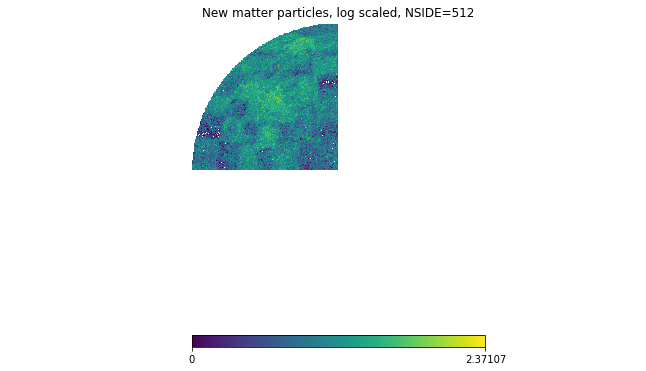

In [17]:
import healpy as hp
def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

nside = 512
# ind = np.unique(np.random.randint(0, len(ra_f), 100*nside**2))
ind = np.where(z_tp < 1.0)[0]

theta_m, phi_m = eq2ang(ra_tp[ind], dec_tp[ind])
# theta_m, phi_m = eq2ang(ra_f, dec_f)
ind_m_f = hp.ang2pix(nside, theta_m, phi_m)
ind_vals, ind_count = np.unique(ind_m_f, return_counts=True)
map_new = np.zeros(hp.nside2npix(nside))
for j in range(len(ind_vals)):
    ind_val = ind_vals[j]
    map_new[ind_val] = ind_count[j]
plt.figure()
hp.mollview(np.log10(map_new), title='New matter particles, log scaled, NSIDE=' + str(nside))
# plt.savefig('new_xyz_mice_matter_cat_nside_' + str(nside) + '.png',dpi=480)






In [19]:
cat_old = fits.open('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/process_cats/matter_ra_dec_r_z_bin_jk_L3072N4096-LC129-1in700_njkradec_180_njkz_1.fits')

ra_o, dec_o, z_o = cat_old[1].data['RA'], cat_old[1].data['DEC'], cat_old[1].data['Z']

print len(ra_o),len(ra_f)




50865143 175595468


In [52]:
# ind = np.unique(np.random.randint(0, len(ra_o), 100*nside**2))
# nside = 32
ind = np.where(z_o < 1.0)[0]

theta_m, phi_m = eq2ang(ra_o[ind], dec_o[ind])
# theta_m, phi_m = eq2ang(ra_o, dec_o)
ind_m_f = hp.ang2pix(nside, theta_m, phi_m)
ind_vals, ind_count = np.unique(ind_m_f, return_counts=True)
map_old = np.zeros(hp.nside2npix(nside))
for j in range(len(ind_vals)):
    ind_val = ind_vals[j]
    map_old[ind_val] = ind_count[j]






/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


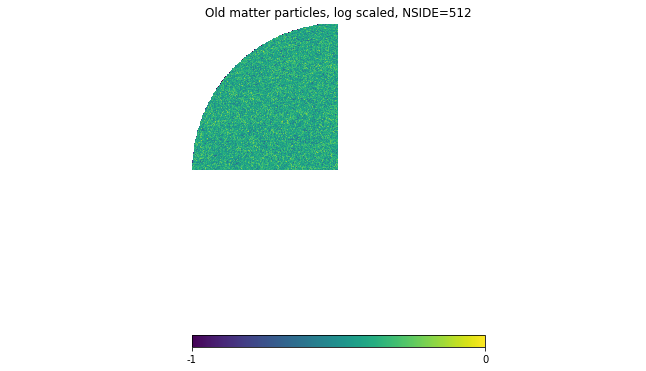

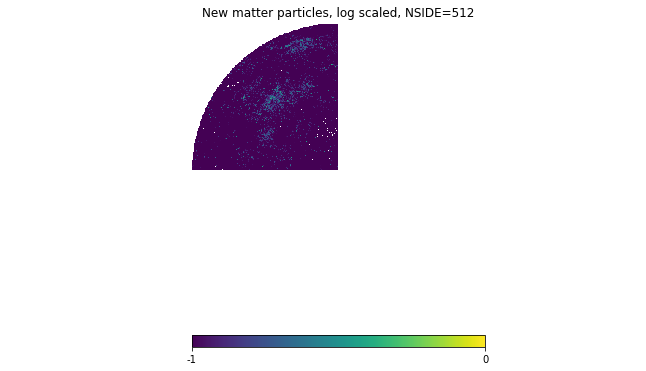

In [53]:
plt.figure()
hp.mollview(np.log10(map_old/np.max(map_old) ), title='Old matter particles, log scaled, NSIDE=' + str(nside), min=-1, max=0.0)
plt.savefig('old_mice_matter_xyz_cat_nside_' + str(nside) + '.png',dpi=480)

plt.figure()
hp.mollview(np.log10(map_new/np.max(map_new)), title='New matter particles, log scaled, NSIDE=' + str(nside), min=-1, max=0.0)
plt.savefig('new_mice_matter_xyz_cat_nside_' + str(nside) + '.png',dpi=480)




In [58]:
nzbins_total = 5000
zarray_all = np.linspace(0.0, 1.0, nzbins_total)
zarray_edges = (zarray_all[1:] + zarray_all[:-1]) / 2.
zarray = zarray_all[1:-1]

nz_unnorm, z_edge = np.histogram(z_f, zarray_edges)
nz_normed_new = nz_unnorm/(integrate.simps(nz_unnorm,zarray))


nz_unnorm, z_edge = np.histogram(z_o, zarray_edges)
nz_normed_old = nz_unnorm/(integrate.simps(nz_unnorm,zarray))






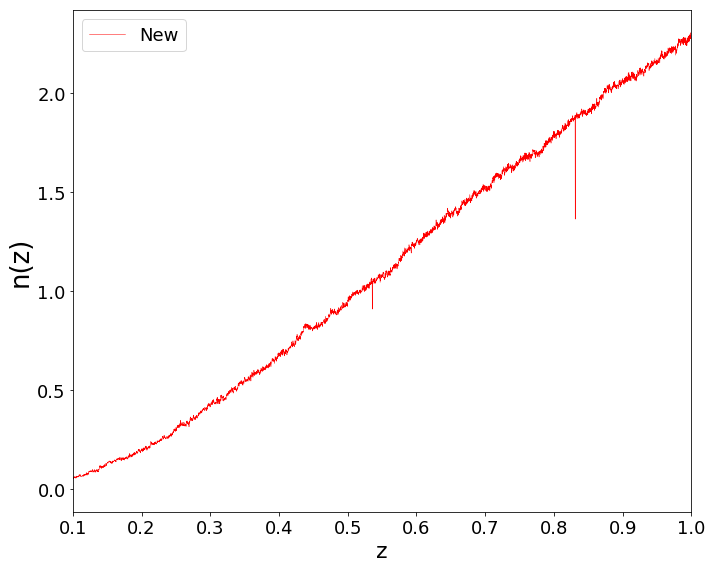

In [60]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.1,1.0)
# ax.set_ylim(0.0,1.0)
ax.plot(zarray, nz_normed_new, 'r-', label='New',linewidth=0.5)
# ax.plot(zarray, nz_normed_old, 'k-', label='Old')

ax.legend(fontsize=18, loc='upper left')
plt.xlabel(r'z', fontsize=22)
plt.ylabel(r'n(z)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
# plt.title('Mass bin ' + str(lmhalo_min)  + '-' + str(lmhalo_max), size=22)
plt.tight_layout()
# plt.savefig('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/process_cats/halos_nz_M_13.0_13.5_theory.png')






In [20]:
nzbins_total = 5000
ra_array_all = np.linspace(0.0, 90, nzbins_total)
ra_array_edges = (ra_array_all[1:] + ra_array_all[:-1]) / 2.
ra_array = ra_array_all[1:-1]

nra_unnorm, z_edge = np.histogram(ra_f, ra_array_edges)
nra_normed_new = nra_unnorm/(integrate.simps(nra_unnorm,ra_array))


nra_unnorm, z_edge = np.histogram(ra_o, ra_array_edges)
nra_normed_old = nra_unnorm/(integrate.simps(nra_unnorm,ra_array))







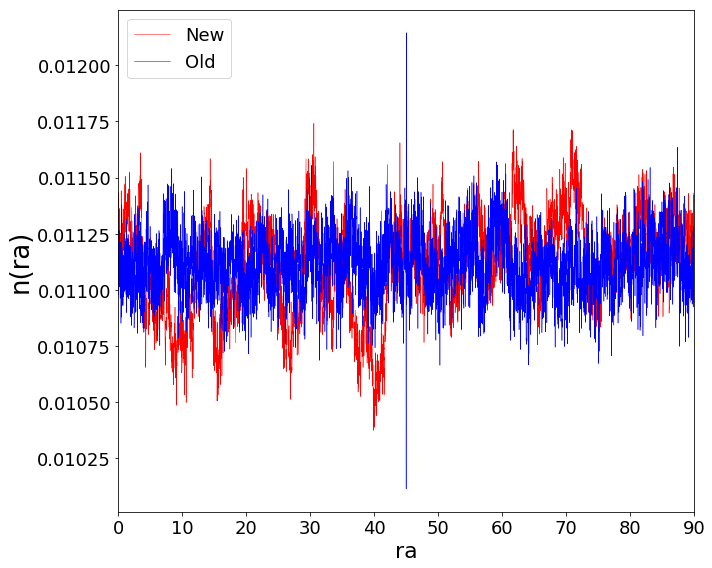

In [21]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.0,90.0)
# ax.set_ylim(0.0,1.0)
ax.plot(ra_array, nra_normed_new, 'r-', label='New',linewidth=0.5)
ax.plot(ra_array, nra_normed_old, 'b-', label='Old',linewidth=0.5)

ax.legend(fontsize=18, loc='upper left')
plt.xlabel(r'ra', fontsize=22)
plt.ylabel(r'n(ra)', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
# plt.title('Mass bin ' + str(lmhalo_min)  + '-' + str(lmhalo_max), size=22)
plt.tight_layout()
# plt.savefig('/global/project/projectdirs/des/shivamp/actxdes/data_set/mice_sims/process_cats/halos_nz_M_13.0_13.5_theory.png')







In [42]:
import pymaster as nmt

mask = np.zeros(hp.nside2npix(nside))
ind_pos = np.where(map_new > 0)[0]
mask[ind_pos] = 1
mask_nmt = nmt.mask_apodization(mask,1.0, apotype="Smooth")




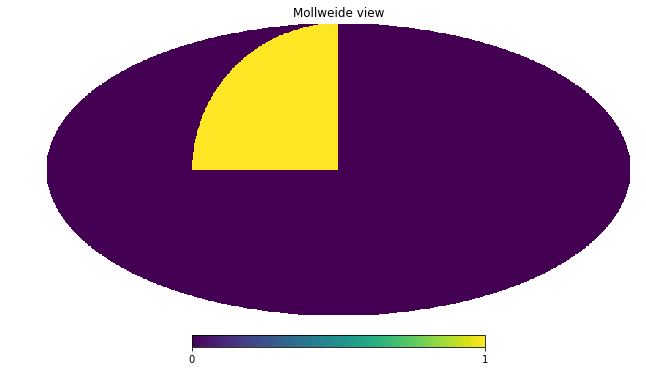

In [43]:
hp.mollview(mask)



In [44]:
f_old = nmt.NmtField(mask_nmt, [map_old])
f_new = nmt.NmtField(mask_nmt, [map_new])




In [45]:
b = nmt.NmtBin(nside, nlb=4)



In [46]:
cl_old_old = nmt.compute_full_master(f_old, f_old, b)

# print cl_old_old


In [47]:
cl_new_new = nmt.compute_full_master(f_new, f_new, b)

# print cl_new_new




In [48]:
cl_old_new = nmt.compute_full_master(f_old, f_new, b)

# print cl_old_new




In [49]:
ell_arr = b.get_effective_ells()




In [30]:
cl_old_new




array([[ 1.66454426e+04, -3.24800605e+03,  7.30399430e+02,
        -1.50830716e+02,  3.90816200e+01, -6.87727132e+00,
         3.49297587e+00,  2.29278105e-01,  8.19944510e-01,
         2.13059920e-01,  5.15376760e-01,  3.40421636e-02,
         4.04614182e-01,  1.40422631e-01,  1.45302915e-01,
         3.68491857e-02,  3.97940333e-02,  6.40679378e-02,
         8.43638732e-02, -8.63600517e-02,  9.05362310e-02,
         6.54412966e-02, -4.26146263e-02, -2.38621843e-02,
         4.62118578e-02,  4.96249407e-03,  3.43425339e-02,
         3.14106742e-02,  5.68331364e-03,  3.82067390e-02,
         7.56413843e-03,  2.42540352e-02,  2.46761228e-02,
         2.38314181e-02,  9.20920002e-03,  2.67008005e-02,
         3.93621177e-03,  2.41266458e-02,  1.41055496e-02,
         1.51333534e-02,  8.55374535e-03,  1.46796887e-02,
         1.32501846e-02,  1.37701707e-02,  1.42680321e-02,
         6.99977632e-03,  7.99858123e-03,  1.37599370e-02,
         1.13161104e-02,  9.23255044e-03,  7.46323884e-0

/global/u1/s/spandey/myenv_new/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


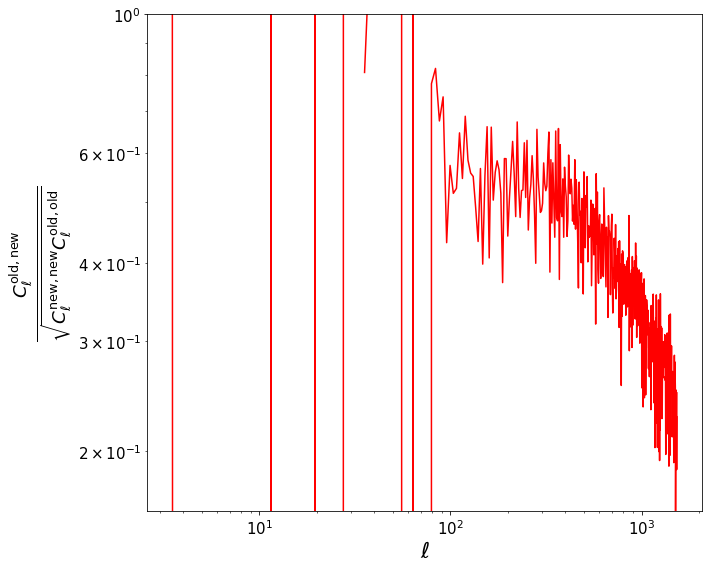

In [50]:
fig, ax = plt.subplots(1,1, figsize = (10,8))

ax.plot(ell_arr, (cl_old_new[0])/(np.sqrt(cl_old_old[0] * cl_new_new[0])), 'r-')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(-1,1)
plt.xlabel(r'$\ell$', fontsize=22)
plt.ylabel(r'$\frac{C^{\rm old,new}_\ell}{\sqrt{C^{\rm new,new}_\ell C^{\rm old,old}_\ell}}$', fontsize=26)
# ax.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)

plt.tight_layout()
plt.savefig('cross_corr_comp.png')






In [37]:
(12*64**2)/8


6144